In [1]:
import os
os.chdir('../')

In [32]:
# FIX total HHI (total share is fucked up)

In [33]:
from source.lib.helpers import *
import pandas as pd
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [59]:
indir_export = Path('drive/output/derived/data_export')
indir_data = Path('drive/output/derived/contributor_stats/contributor_data')

time_period = 6
df_panel = pd.read_parquet('issue/df_project_departed.parquet')
df_contributor_characteristics = pd.read_parquet('issue/contributor_covariates.parquet')
df_contributor_panel = pd.read_parquet(indir_data / f"major_contributors_major_months{time_period}_window732D_samplefull.parquet")
df_issue = pd.read_parquet(indir_export / 'df_issue.parquet')

# Uncooperative individuals get less cooperative over time as evidenced by first two

(166,)


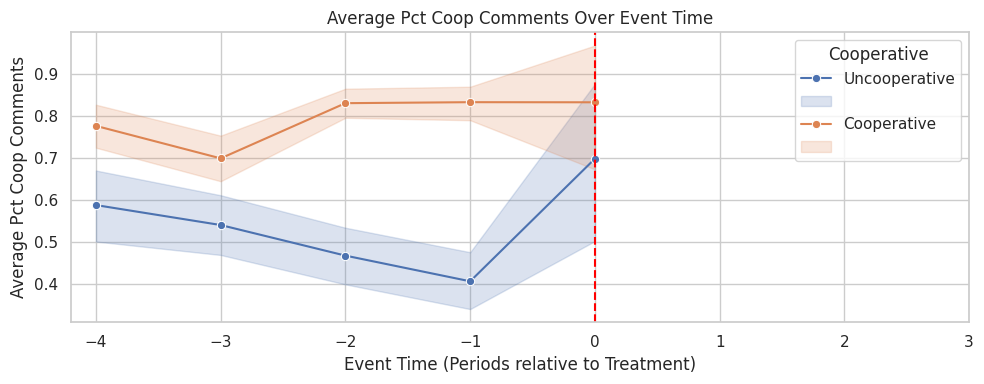

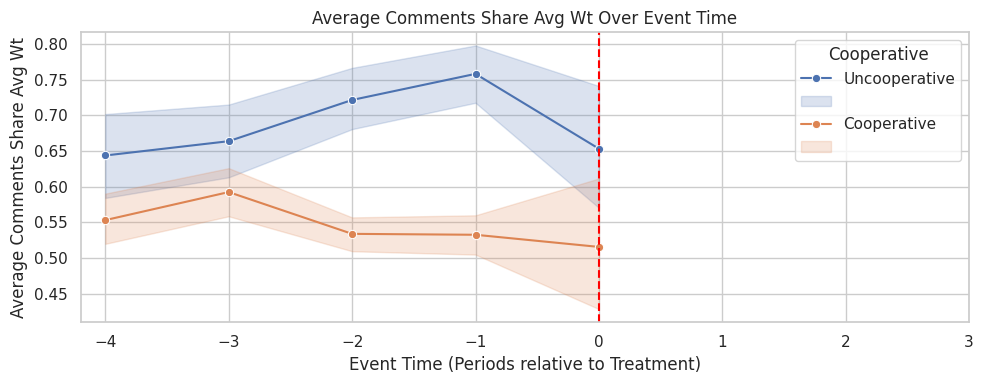

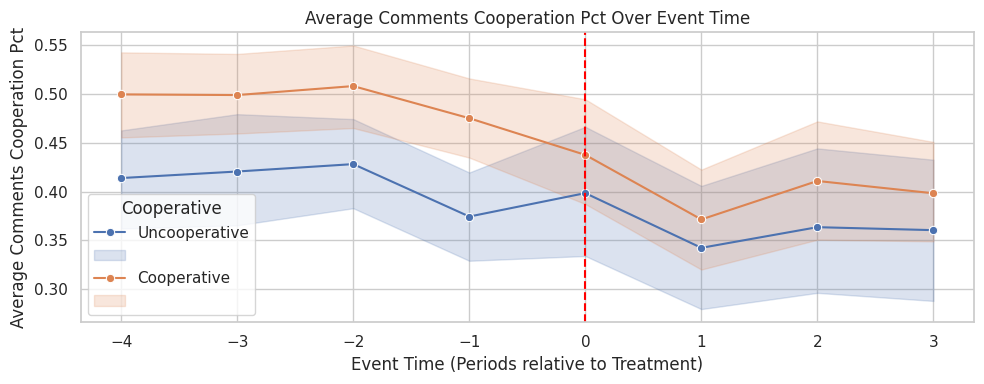

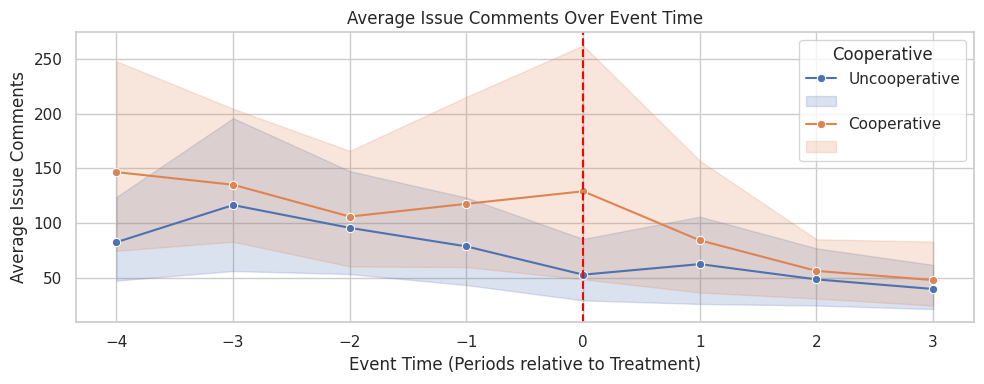

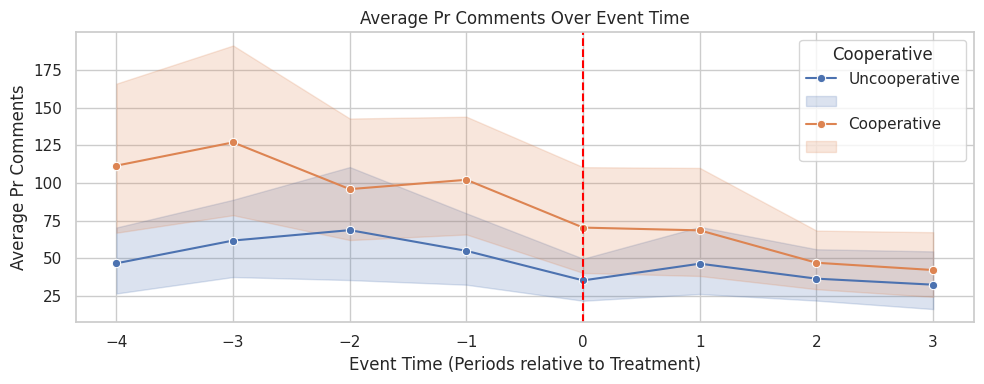

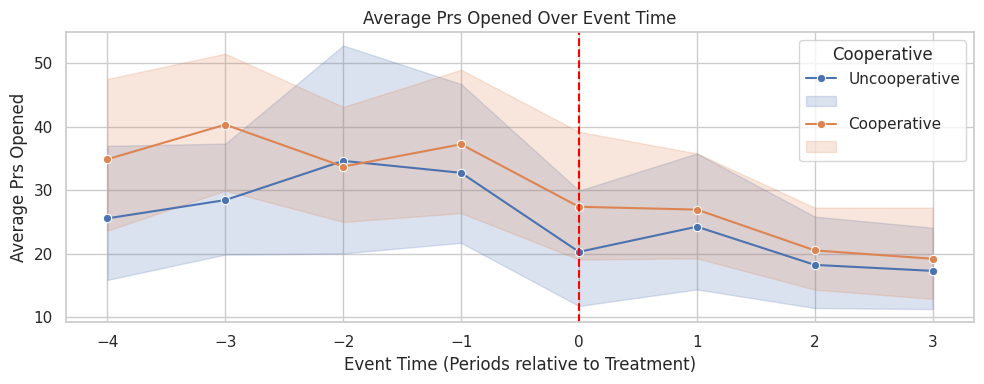

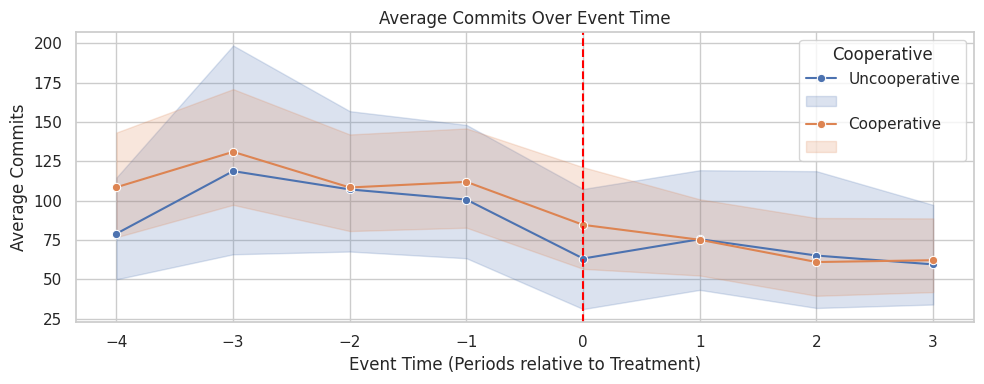

In [35]:
df_panel_focus = df_panel.assign(event_time = (df_panel['time_index'] - df_panel['treatment_group']).astype(int))
include_repos = df_panel_focus.query('event_time == -4')['repo_name'].unique().tolist()
df_panel_focus = df_panel_focus.query('event_time <= 3 & event_time >= -4').query(f'repo_name.isin({include_repos})')
print(df_panel_focus['repo_name'].unique().shape)

plot_vars_imp = ['pct_coop_comments','comments_share_avg_wt', 'comments_cooperation_pct', 'issue_comments', 'pr_comments', 'prs_opened','commits']
plot_vars_others = ['issue_comments', 'pr_comments', 'contributors', 'pct_coop_commits_count', 'commits', 'prs_merged', 'closed_issue']
sns.set_style("whitegrid")

for var in plot_vars_imp:
    plt.figure(figsize=(10,4))
    sns.lineplot(data=df_panel_focus, x='event_time', y=var, hue='pct_coop_comments_bin_2', hue_order=[0, 1], marker='o', errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'Average {var.replace("_", " ").title()} Over Event Time')
    plt.xlabel('Event Time (Periods relative to Treatment)')
    plt.ylabel(f'Average {var.replace("_", " ").title()}')
    plt.legend(title='Cooperative', labels=['Uncooperative',"",'Cooperative',""])
    plt.xticks(range(df_panel_focus['event_time'].min(), df_panel_focus['event_time'].max()+1))
    plt.tight_layout()
    plt.show()


In [50]:
time_mapping = df_panel_focus[['time_period', 'time_index']].drop_duplicates().set_index('time_period')['time_index'].to_dict()
repo_treatment_mapping = df_panel_focus[['repo_name', 'treatment_group']].drop_duplicates().set_index('repo_name')['treatment_group'].to_dict()
repo_list = df_panel_focus.query('event_time == -4')['repo_name'].unique().tolist()
departed_actor_id = df_panel_focus[['repo_name','departed_actor_id']].drop_duplicates()
cooperative_project = df_panel_focus[['repo_name','pct_coop_comments_bin_2']].set_index('repo_name')['pct_coop_comments_bin_2'].to_dict()

def CleanDF(df, repo_list, time_mapping, repo_treatment_mapping, departed_actor_id, cooperative_project):
    df = df[df['repo_name'].isin(repo_list)]
    df['time_index'] = df['time_period'].map(time_mapping)
    df['treatment_group'] = df['repo_name'].map(repo_treatment_mapping)
    df = df.query('~time_index.isna()')
    df = df.assign(event_time=(df['time_index'] - df['treatment_group']).astype(int))
    df = df.query('event_time <= 4 & event_time >= -4')
    df = df.merge(departed_actor_id.rename({'departed_actor_id':'actor_id'}, axis = 1).assign(group = 'Departed'), how = 'left')
    df['group'] = df['group'].fillna('Other')
    df['cooperative'] = np.where(df['repo_name'].map(cooperative_project) == 1, 'Cooperative','Uncooperative')
    df['group'] = df['group'] + "_" + df['cooperative']
    return df


/tmp/user/20506/ipykernel_2603382/729703048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_index'] = df['time_period'].map(time_mapping)
/tmp/user/20506/ipykernel_2603382/729703048.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment_group'] = df['repo_name'].map(repo_treatment_mapping)


(166,)


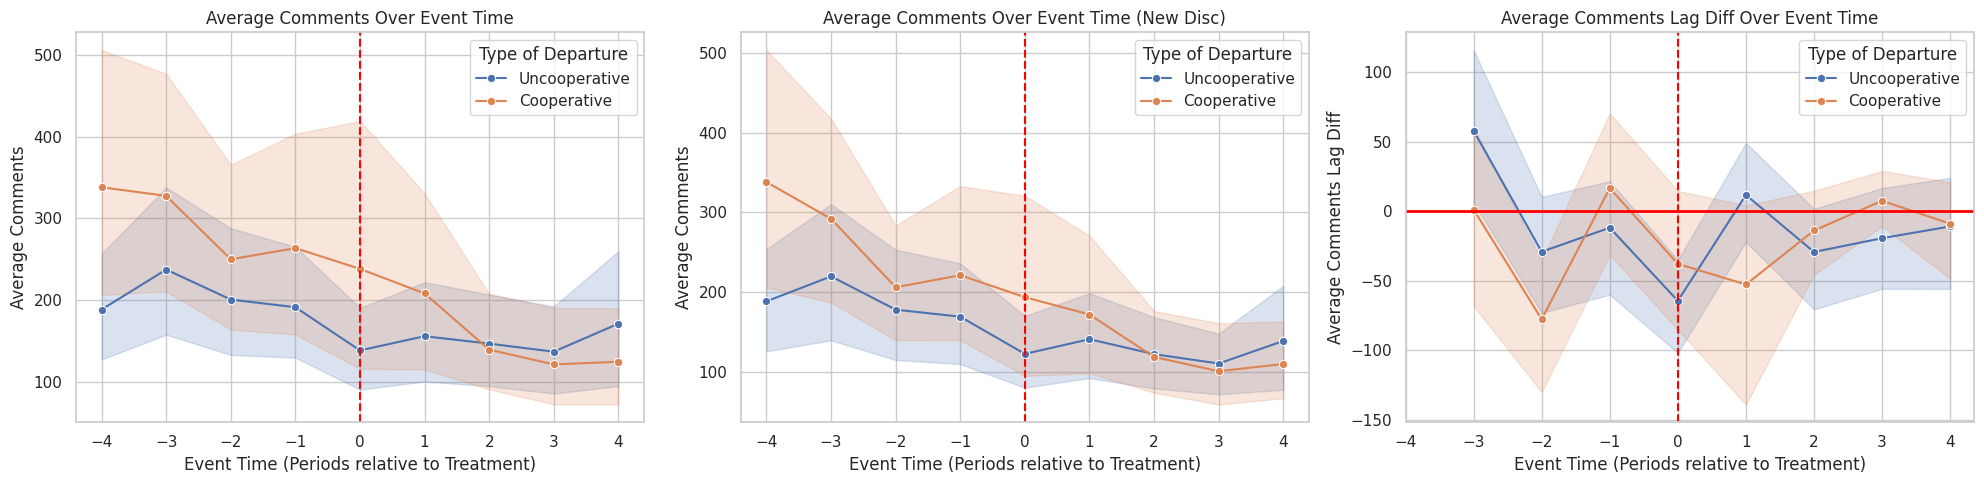

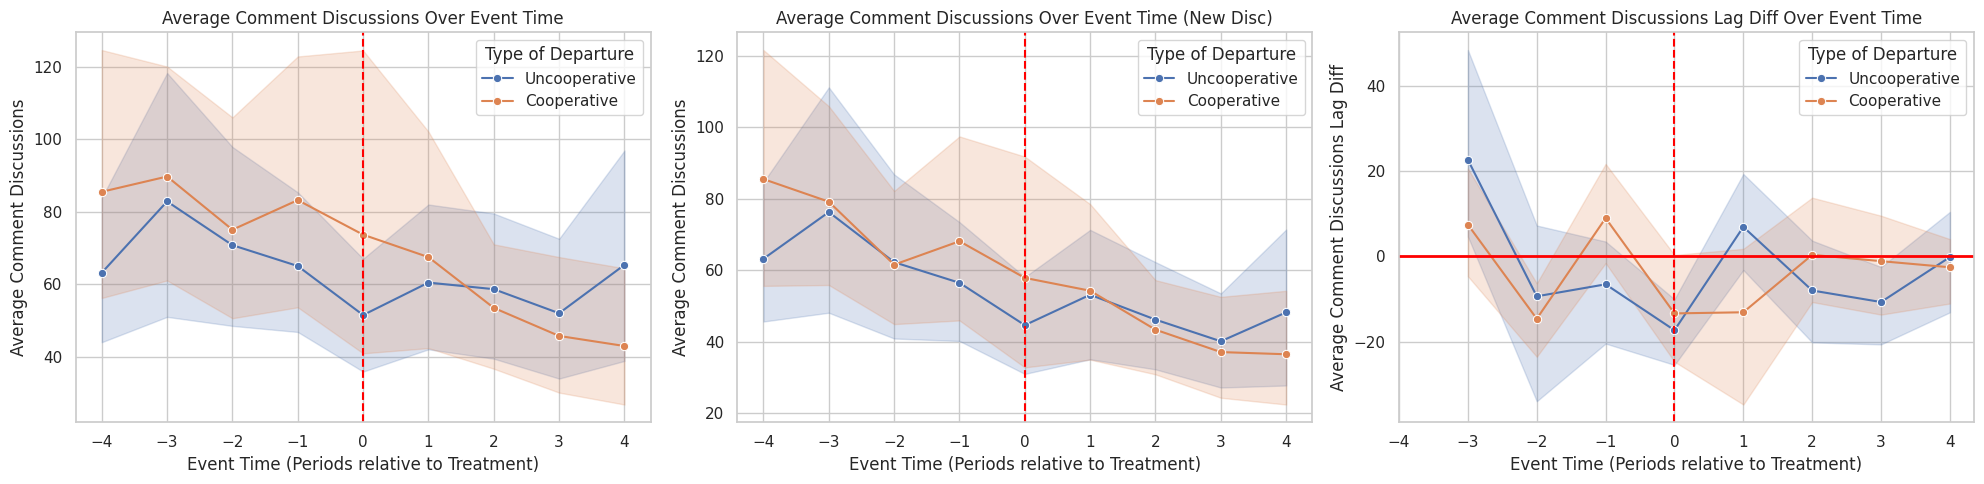

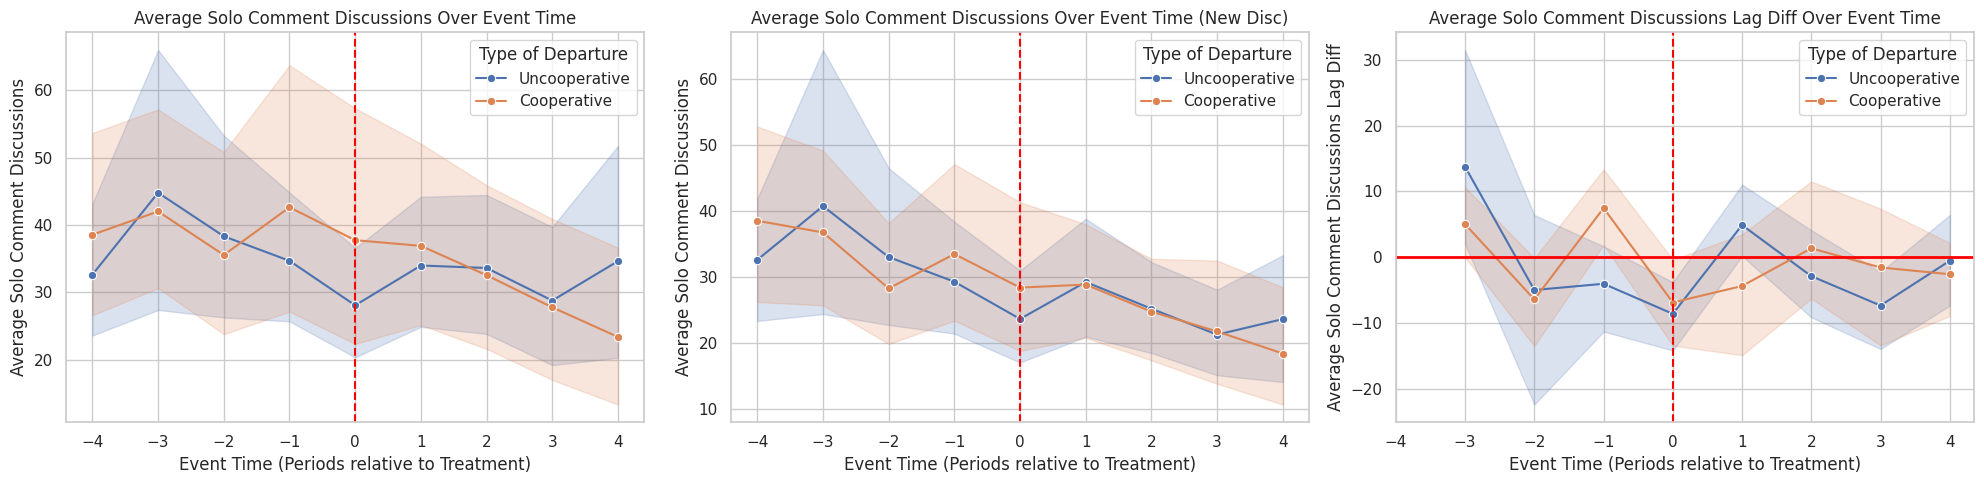

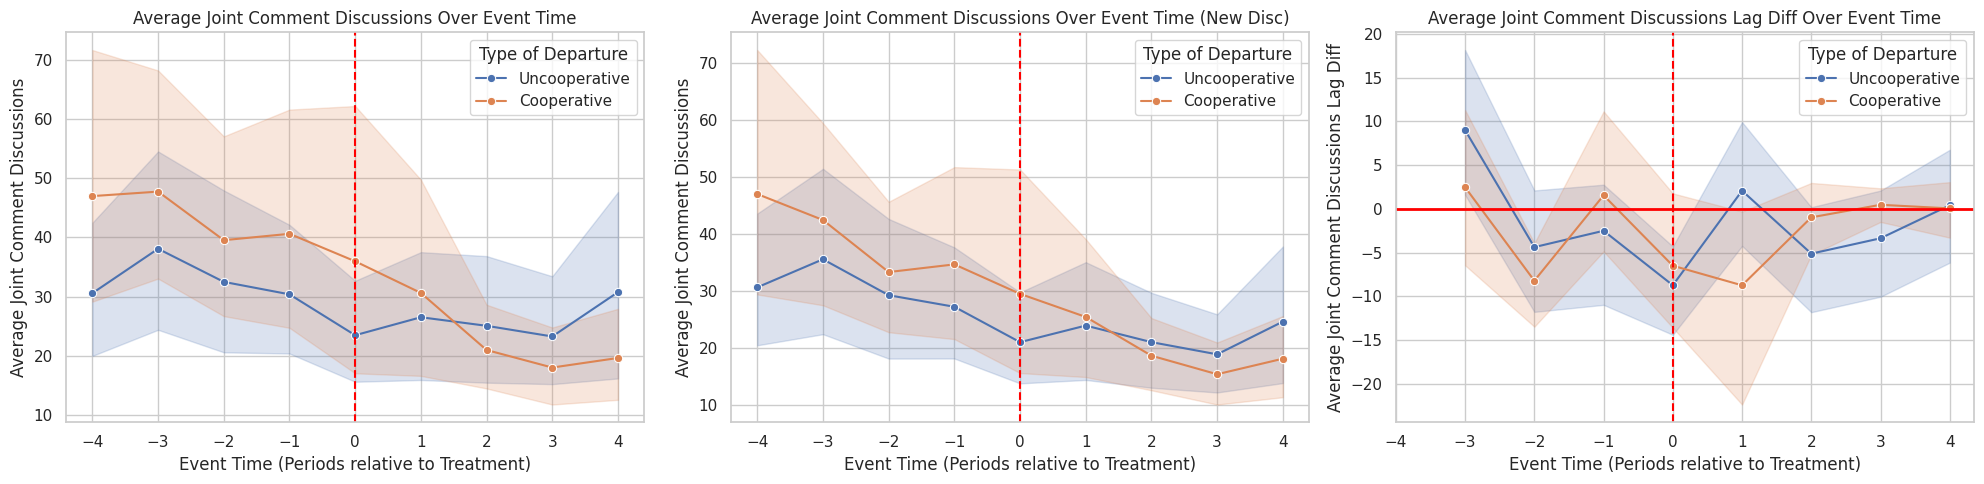

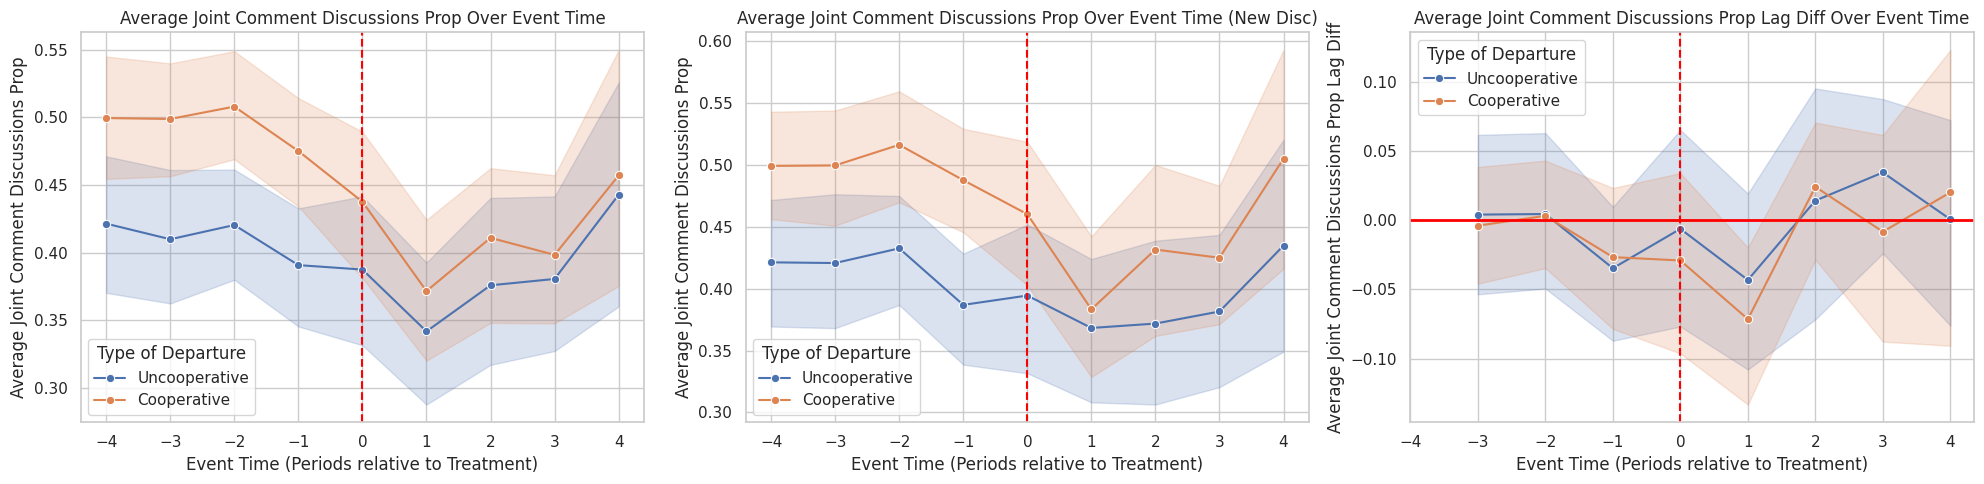

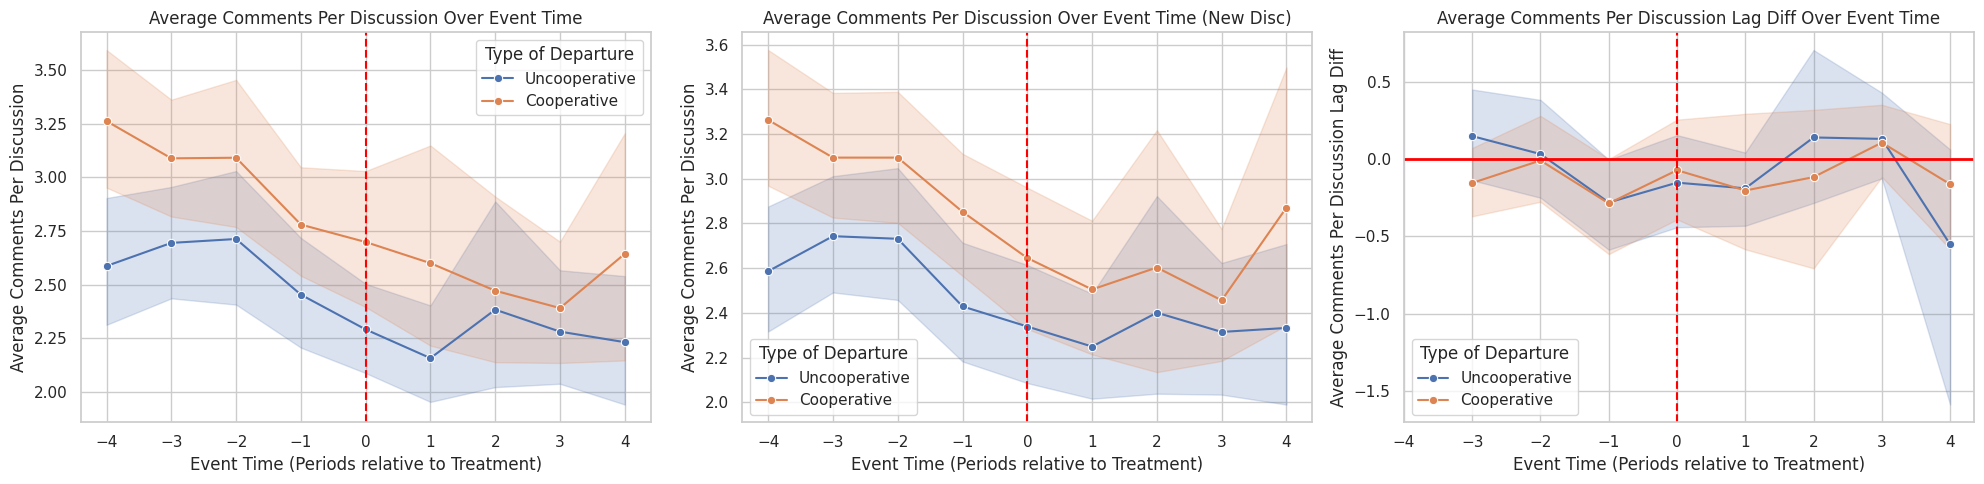

In [51]:
df_comments_actor = pd.read_parquet('issue/df_comments_actor.parquet')
contributor_vars = ['comments','comment_discussions','solo_comment_discussions','joint_comment_discussions']
df_comments_actor_focus = CleanDF(df_comments_actor, repo_list, time_mapping, repo_treatment_mapping, departed_actor_id, cooperative_project)
print(df_comments_actor_focus['repo_name'].unique().shape)
df_comments_actor_focus['comments'] = df_comments_actor_focus.groupby(['repo_name','time_period','issue_number'])['comments'].transform('sum')
df_comments_actor_focus['comment_discussions'] = 1
df_comments_actor_focus['solo_comment_discussions'] = (df_comments_actor_focus['comments_share'] == 1).astype(int)
df_comments_actor_focus['joint_comment_discussions'] = (df_comments_actor_focus['comments_share'] != 1).astype(int)
df_comments_actor_focus = df_comments_actor_focus.drop_duplicates(['repo_name','time_period','issue_number'])
summary_indiv = df_comments_actor_focus.groupby(['event_time', 'repo_name', 'cooperative'])[contributor_vars].agg('sum').reset_index()
summary_indiv['joint_comment_discussions_prop'] = summary_indiv['joint_comment_discussions']/summary_indiv['comment_discussions']
summary_indiv['comments_per_discussion'] = summary_indiv['comments']/summary_indiv['comment_discussions']

analysis_vars = contributor_vars + ['joint_comment_discussions_prop','comments_per_discussion']
analysis_vars_lag = [f"{col}_lag_diff" for col in analysis_vars]
summary_indiv[analysis_vars_lag] = summary_indiv.sort_values('event_time').groupby(['repo_name', 'cooperative'])[analysis_vars].shift(1)
summary_indiv[analysis_vars_lag] = summary_indiv[analysis_vars].values - summary_indiv[analysis_vars_lag]

df_comments_actor_focus_uq = df_comments_actor_focus.sort_values(['repo_name','time_period','issue_number']).drop_duplicates(['repo_name','issue_number'])
summary_indiv_uq = df_comments_actor_focus_uq.groupby(['event_time', 'repo_name', 'cooperative'])[contributor_vars].agg('sum').reset_index()
summary_indiv_uq['joint_comment_discussions_prop'] = summary_indiv_uq['joint_comment_discussions']/summary_indiv_uq['comment_discussions']
summary_indiv_uq['comments_per_discussion'] = summary_indiv_uq['comments']/summary_indiv_uq['comment_discussions']



# Ensure that seaborn's style is set for better aesthetics
sns.set(style="whitegrid")

# Iterate through each variable in analysis_vars
for var in analysis_vars:
    lag_var = f"{var}_lag_diff"
    if lag_var in analysis_vars_lag:
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        sns.lineplot(data=summary_indiv,x='event_time',y=var,hue='cooperative',marker='o',errorbar=('ci', 95),ax=axes[0])
        axes[0].axvline(x=0, color='red', linestyle='--')
        axes[0].set_title(f'Average {var.replace("_", " ").title()} Over Event Time')
        axes[0].set_xlabel('Event Time (Periods relative to Treatment)')
        axes[0].set_ylabel(f'Average {var.replace("_", " ").title()}')
        axes[0].legend(title='Type of Departure')
        axes[0].set_xticks(range(summary_indiv['event_time'].min(), summary_indiv['event_time'].max() + 1))

        
        sns.lineplot(data=summary_indiv_uq,x='event_time',y=var,hue='cooperative',marker='o',errorbar=('ci', 95),ax=axes[1])
        axes[1].axvline(x=0, color='red', linestyle='--')
        axes[1].set_title(f'Average {var.replace("_", " ").title()} Over Event Time (New Disc)')
        axes[1].set_xlabel('Event Time (Periods relative to Treatment)')
        axes[1].set_ylabel(f'Average {var.replace("_", " ").title()}')
        axes[1].legend(title='Type of Departure')
        axes[1].set_xticks(range(summary_indiv_uq['event_time'].min(), summary_indiv_uq['event_time'].max() + 1))

        sns.lineplot(data=summary_indiv,x='event_time',y=lag_var,hue='cooperative',marker='o',errorbar=('ci', 95),ax=axes[2])
        axes[2].axvline(x=0, color='red', linestyle='--')
        axes[2].axhline(y=0, color='red', linewidth=2)
        axes[2].set_title(f'Average {lag_var.replace("_", " ").title()} Over Event Time')
        axes[2].set_xlabel('Event Time (Periods relative to Treatment)')
        axes[2].set_ylabel(f'Average {lag_var.replace("_", " ").title()}')
        axes[2].legend(title='Type of Departure')
        axes[2].set_xticks(range(summary_indiv['event_time'].min(), summary_indiv['event_time'].max() + 1))
        plt.tight_layout()
        plt.show()


# cooperative contributors spend more effort on each discussion?
# spike is driven by an increase in solo discussions
# are they more productive???

# aside: why is there a decrease in comments/discussions by cooperative? Are they getting ready to hand off?

In [52]:
# why was there an increase in solo discussions
# and how did the number of total solo discussions change

<Figure size 1000x600 with 0 Axes>

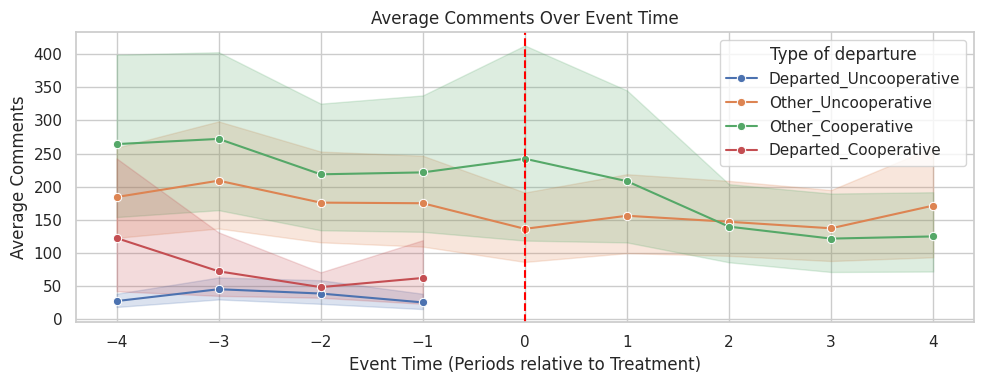

<Figure size 1000x600 with 0 Axes>

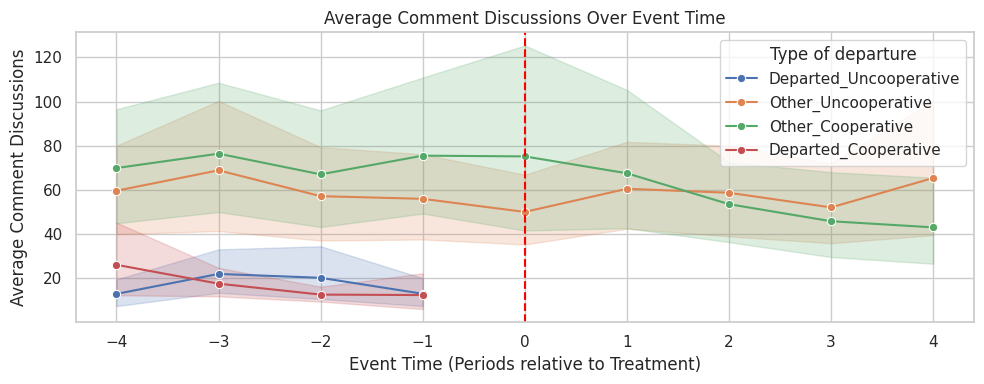

<Figure size 1000x600 with 0 Axes>

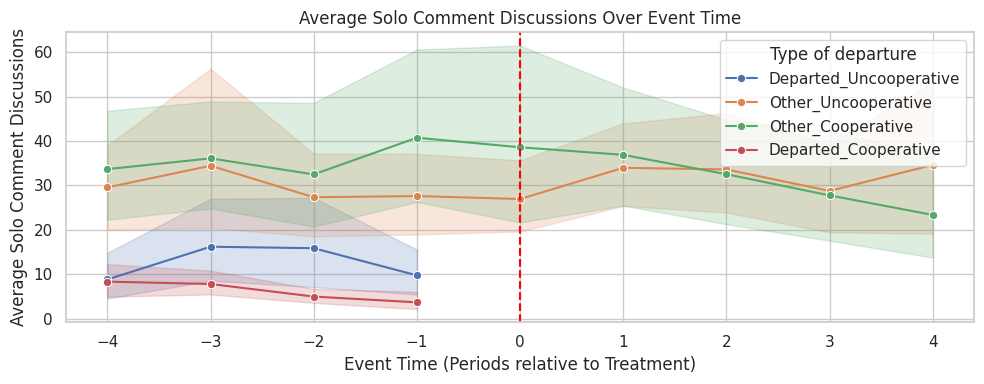

<Figure size 1000x600 with 0 Axes>

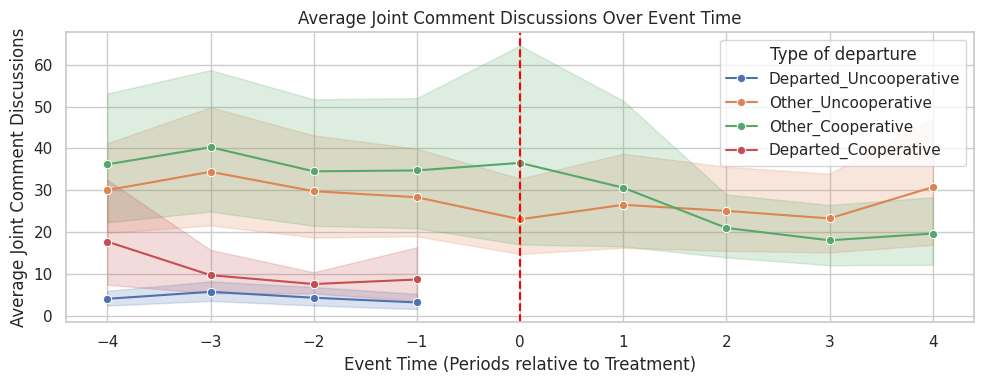

<Figure size 1000x600 with 0 Axes>

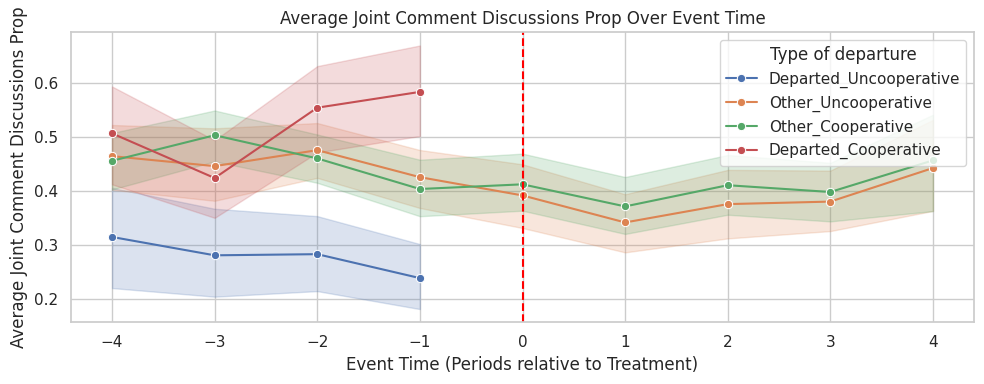

<Figure size 1000x600 with 0 Axes>

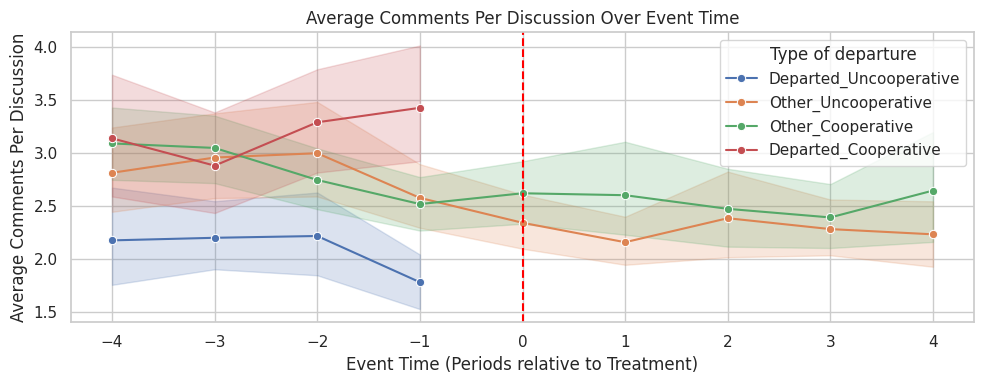

In [53]:
summary_indiv = df_comments_actor_focus.groupby(['event_time', 'repo_name', 'group'])[contributor_vars].agg('sum').reset_index()
summary_indiv = summary_indiv[summary_indiv.apply(lambda x: 'Departed' not in x['group'] or 'Departed' in x['group'] and x['event_time']<=-1, axis = 1)]
summary_indiv['joint_comment_discussions_prop'] = summary_indiv['joint_comment_discussions']/summary_indiv['comment_discussions']
summary_indiv['comments_per_discussion'] = summary_indiv['comments']/summary_indiv['comment_discussions']

for var in contributor_vars + ['joint_comment_discussions_prop','comments_per_discussion']:
    plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10,4))
    sns.lineplot(data=summary_indiv, x='event_time', y=f'{var}', hue='group', marker='o', errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'Average {var.replace("_", " ").title()} Over Event Time')
    plt.xlabel('Event Time (Periods relative to Treatment)')
    plt.ylabel(f'Average {var.replace("_", " ").title()}')
    plt.legend(title='Type of departure')
    plt.xticks(range(summary_indiv['event_time'].min(), summary_indiv['event_time'].max()+1))
    plt.tight_layout()
    plt.show()

/tmp/user/20506/ipykernel_2603382/729703048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_index'] = df['time_period'].map(time_mapping)
/tmp/user/20506/ipykernel_2603382/729703048.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment_group'] = df['repo_name'].map(repo_treatment_mapping)


<Figure size 1000x600 with 0 Axes>

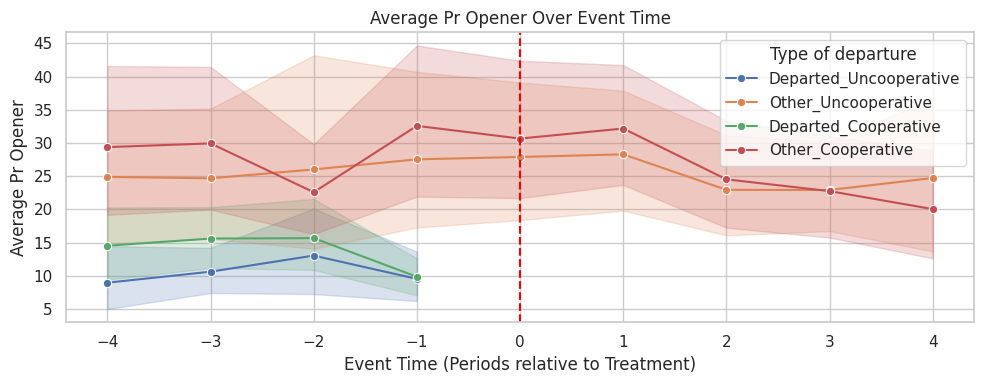

<Figure size 1000x600 with 0 Axes>

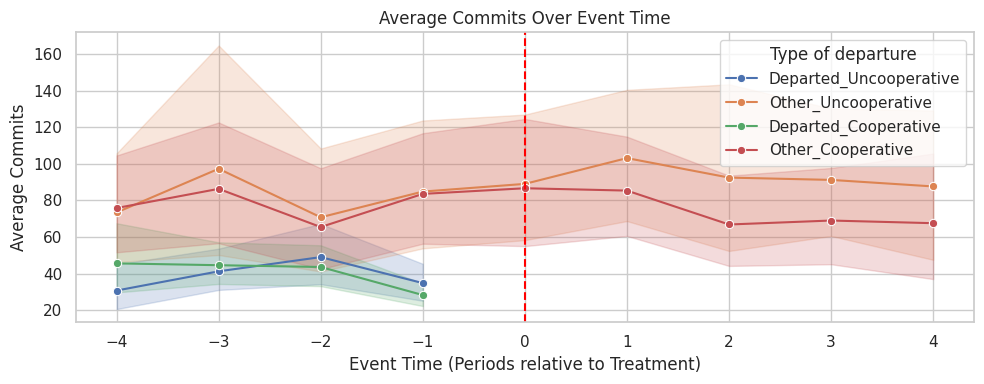

<Figure size 1000x600 with 0 Axes>

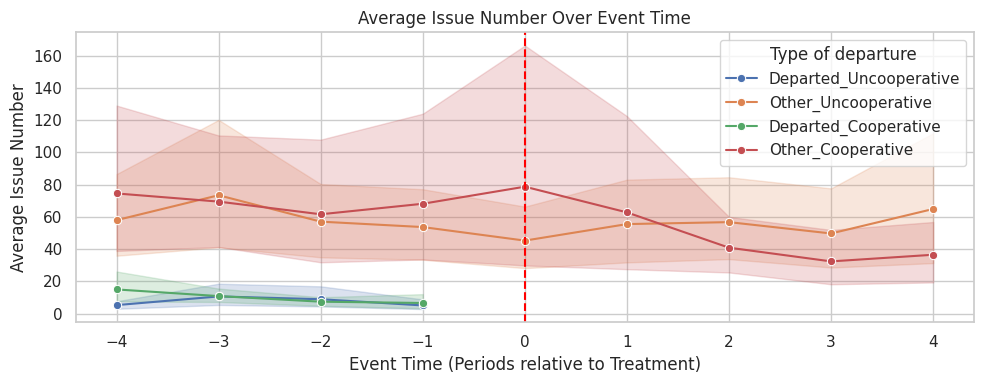

<Figure size 1000x600 with 0 Axes>

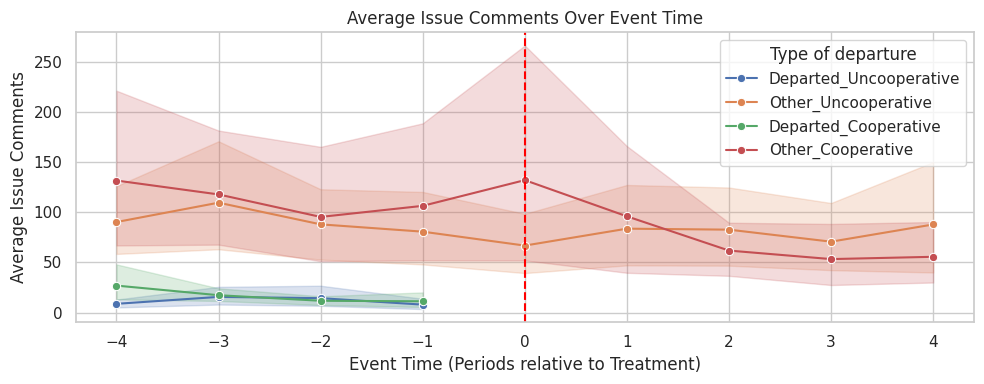

In [54]:
df_contributor_panel_focus = CleanDF(df_contributor_panel, repo_list, time_mapping, repo_treatment_mapping, departed_actor_id, cooperative_project)
contributor_vars = ['pr_opener','commits','issue_number', 'issue_comments']
summary_indiv = df_contributor_panel_focus.groupby(['event_time', 'repo_name', 'group'])[contributor_vars].agg('sum').reset_index()

for var in contributor_vars:
    plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10,4))
    sns.lineplot(data=summary_indiv[summary_indiv.apply(lambda x: 'Departed' not in x['group'] or 'Departed' in x['group'] and x['event_time']<=-1, axis = 1)], x='event_time', y=f'{var}', hue='group', marker='o', errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'Average {var.replace("_", " ").title()} Over Event Time')
    plt.xlabel('Event Time (Periods relative to Treatment)')
    plt.ylabel(f'Average {var.replace("_", " ").title()}')
    plt.legend(title='Type of departure')
    plt.xticks(range(summary_indiv['event_time'].min(), summary_indiv['event_time'].max()+1))
    plt.tight_layout()
    plt.show()

In [55]:
summary_indiv

,event_time,repo_name,group,pr_opener,commits,issue_number,issue_comments
0,-4,Azure/azure-uamqp-python,Departed_Uncooperative,20.0,33.0,9.0,12.0
1,-4,Azure/azure-uamqp-python,Other_Uncooperative,0.0,0.0,8.0,11.0
2,-4,CartoDB/carto-python,Departed_Cooperative,0.0,0.0,1.0,3.0
3,-4,CartoDB/carto-python,Other_Cooperative,2.0,8.0,18.0,36.0
4,-4,City-of-Helsinki/django-helusers,Departed_Uncooperative,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...
1930,4,twilio/twilio-python,Other_Uncooperative,40.0,74.0,23.0,33.0
1931,4,ultrabug/py3status,Other_Cooperative,25.0,91.0,75.0,131.0
1932,4,vmware/pyvcloud,Other_Cooperative,30.0,69.0,26.0,42.0
1933,4,webrecorder/pywb,Other_Cooperative,16.0,68.0,15.0,18.0


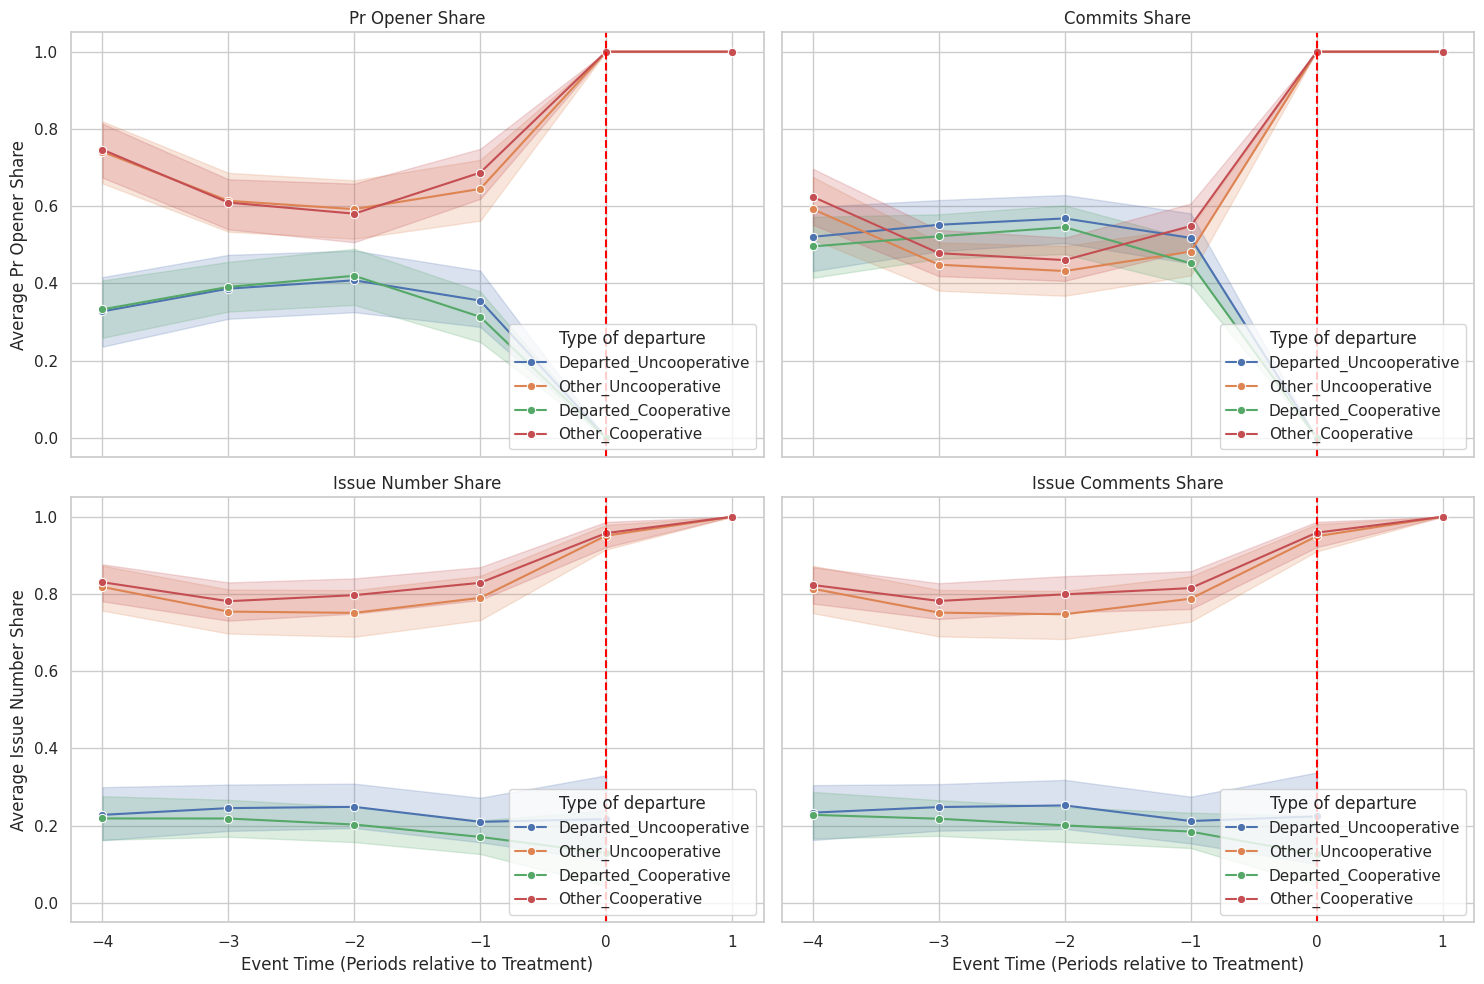

In [56]:
summary_indiv[[f"{c}_share" for c in contributor_vars]] =  summary_indiv[contributor_vars] / summary_indiv.groupby(['repo_name','event_time'])[contributor_vars].transform('sum')
num_rows, num_cols = 2, 2
num_vars = len(contributor_vars)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  

for i, var in enumerate(contributor_vars):
    if i >= num_rows * num_cols:
        break  # Avoid indexing errors if there are more variables than plots
    
    ax = axes[i]
    sns.lineplot(data=summary_indiv[summary_indiv['event_time']<=1], x='event_time', y=f'{var}_share', hue='group', marker='o', errorbar=('ci', 95), ax = ax)
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'{var.replace("_", " ").title()} Share')
    ax.set_xlabel('Event Time (Periods relative to Treatment)')
    ax.set_ylabel(f'Average {var.replace("_", " ").title()} Share')
    ax.legend(title='Type of departure', loc = 'lower right')
    ax.set_xticks(range(summary_indiv['event_time'].min(), 2,1))
    ax.set_ylim(-0.05,1.05)
    
plt.tight_layout()
plt.savefig('issue/event_study/explore/contributor_type_share.png')
plt.show()


In [84]:
df_issue_repo = df_issue[df_issue['repo_name'].isin(df_panel['repo_name'].unique())]
df_issue_repo = ImputeTimePeriod(df_issue_repo, 6)
df_time_index = df_panel[['time_period','time_index']].drop_duplicates()
df_time_index['time_period'] = pd.to_datetime(df_time_index['time_period'])
df_issue_repo = pd.merge(df_issue_repo, df_time_index)

/scratch/chrisliao/oss_hierarchy/source/lib/helpers.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = pd.to_datetime(df['created_at'])
/scratch/chrisliao/oss_hierarchy/source/lib/helpers.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['created_at'].apply(lambda x: x.year)
/scratch/chrisliao/oss_hierarchy/source/lib/helpers.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [198]:
df_repo_periods = df_issue_repo[['repo_name','actor_id','time_index']].drop_duplicates()
df_repo_periods['time_min'] = df_repo_periods.groupby(['actor_id','repo_name'])['time_index'].transform('min')
df_repo_periods = pd.merge(df_repo_periods, 
                           df_panel[['repo_name','treatment_group', 'departed_actor_id', 'pct_coop_comments_bin_2']].drop_duplicates())\
    .query('time_min < treatment_group')\
    .drop(['time_index'], axis = 1)\
    .drop_duplicates()

In [199]:
df_actor_issues = df_issue_repo.groupby(['actor_id', 'repo_name'])['issue_number'].apply(set).reset_index().rename(columns={'issue_number': 'issues'})
df_result = df_repo_periods.merge(df_actor_issues, on=['actor_id', 'repo_name'], how='left')
df_result = df_result.merge(df_actor_issues, left_on=['departed_actor_id','repo_name'], right_on=['actor_id','repo_name'], how='left', suffixes=('','_dep'))
df_result['common_issues'] = df_result.apply(lambda row: list(row['issues'].intersection(row['issues_dep'])) if isinstance(row['issues'], set) and isinstance(row['issues_dep'], set) else [], axis=1)
df_result['had_common_issue'] = df_result['common_issues'].apply(lambda x: len(x) > 0)
df_result['num_common_issue'] = df_result['common_issues'].apply(lambda x: len(x))
print(df_result.groupby('pct_coop_comments_bin_2')['had_common_issue'].mean())
print(df_result.groupby('pct_coop_comments_bin_2')['num_common_issue'].mean())

pct_coop_comments_bin_2
0.0    0.247649
1.0    0.336423
Name: had_common_issue, dtype: float64
pct_coop_comments_bin_2
0.0    1.087967
1.0    1.539399
Name: num_common_issue, dtype: float64


In [200]:
df_temp = pd.merge(df_contributor_panel, df_result[~df_result['pct_coop_comments_bin_2'].isna()])
df_temp = pd.merge(df_temp, df_time_index).assign(event_time = lambda x: x.time_index - x.treatment_group).query('event_time >= -4 & event_time < 4')
df_temp['group'] = df_temp['had_common_issue'].astype(str) + "_" + df_temp['pct_coop_comments_bin_2'].astype(str) 

"""
for var in contributor_vars:
    plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10,4))
    sns.lineplot(data=df_temp.groupby(['repo_name','event_time','group'])[contributor_vars].mean().reset_index(), x='event_time', y=f'{var}', hue='group', marker='o', errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'Average {var.replace("_", " ").title()} Over Event Time')
    plt.xlabel('Event Time (Periods relative to Treatment)')
    plt.ylabel(f'Average {var.replace("_", " ").title()}')
    plt.legend(title='Common Issue x Cooperated')
    plt.xticks(range(summary_indiv['event_time'].min(), summary_indiv['event_time'].max()+1))
    plt.tight_layout()
    plt.show()
"""
df_temp.assign(contributors = 1).groupby(['repo_name','had_common_issue','time_index','treatment_group','pct_coop_comments_bin_2'])[contributor_vars+['contributors']].sum().reset_index().to_csv('issue/temp_common_contributors.csv')